In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json

In [4]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(12,8)})

In [81]:
def load_json_item(path,columns=['title','category']):
    data = []
    with open(path,'r',encoding='utf-8') as f:
        for line in f:
            data.append({k:v for k,v in json.loads(line).items() if k in columns})
    return pd.DataFrame(data,columns=columns)

In [100]:
path = '../items.json'
df = load_json_item(path)
df['category'] = df['category']
df.head()

,title,category
0,Captive Medic's Bodycam Shows Firsthand Horror...,World News
1,Russia Is Firing Its Senior Commanders. What D...,World News
2,LinkedIn Settles With U.S. Over Alleged Pay Di...,Business
3,Starbucks Workers Have Unionized More Than 50 ...,Business
4,Red Cross Registers Hundreds Of Ukrainian POWs...,World News


(array([0, 1, 2]),
 [Text(0, 0, 'Business'),
  Text(1, 0, 'Entertainment'),
  Text(2, 0, 'World News')])

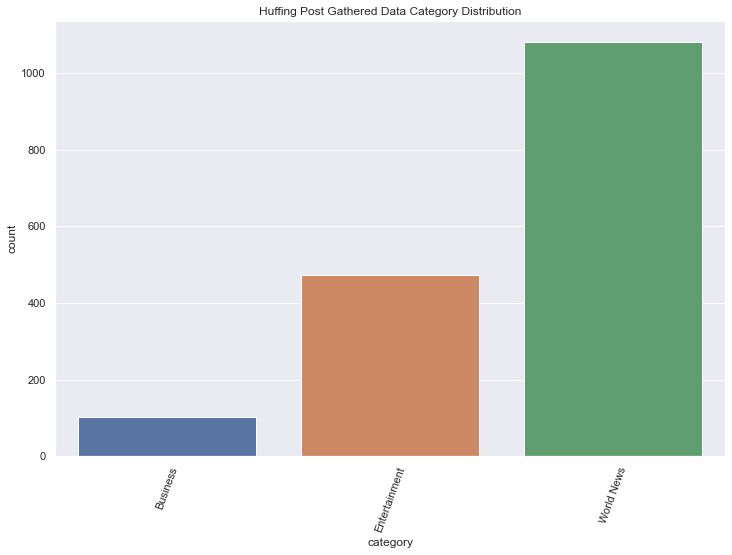

In [12]:
dff= df.groupby('category').count().reset_index()
dff.columns = ['category','count']
plt.title('Huffing Post Gathered Data Category Distribution')
sns.barplot(x="category", y="count", data=dff)
plt.xticks(rotation=70)

In [13]:
df.head()

,title,category
0,Captive Medic's Bodycam Shows Firsthand Horror...,World News
1,Russia Is Firing Its Senior Commanders. What D...,World News
2,LinkedIn Settles With U.S. Over Alleged Pay Di...,Business
3,Starbucks Workers Have Unionized More Than 50 ...,Business
4,Red Cross Registers Hundreds Of Ukrainian POWs...,World News


In [14]:
## preprocess

In [17]:
# %pip install -U spacy

In [18]:
import spacy
stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',
                             header=None,
                             squeeze=True).tolist())

In [19]:
def clean_doc(d):
    doc = []
    for t in d:
        if not any([t.is_stop, t.is_digit, not t.is_alpha, t.is_punct, t.is_space, t.lemma_ == '-PRON-']):        
            doc.append(t.lemma_)
    return ' '.join(doc)    

In [23]:
# !python -m spacy download en_core_web_sm

In [58]:
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 6000000
# nlp.disable_pipes('ner')
# # nlp.disable_pipes('tok2vec')
# nlp.disable_pipes('attribute_ruler')
# nlp.disable_pipes('lemmatizer')

In [59]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [60]:
def preprocess(articles):
    iter_articles = (article for article in articles)
    clean_articles = []
    for i, doc in enumerate(nlp.pipe(iter_articles, 
                                     batch_size=100, 
                                     n_process=8), 1):
        if i % 1000 == 0:
            print(f'{i / len(articles):.2%}', end=' ', flush=True)
        clean_articles.append(clean_doc(doc))
    return clean_articles

In [101]:
df['cleanTitle'] = preprocess(df['title'])

60.31% 

In [102]:
df.head()

,title,category,cleanTitle
0,Captive Medic's Bodycam Shows Firsthand Horror...,World News,Captive Medic Bodycam show Firsthand Horror Ma...
1,Russia Is Firing Its Senior Commanders. What D...,World News,Russia fire senior commander mean Ukraine War
2,LinkedIn Settles With U.S. Over Alleged Pay Di...,Business,LinkedIn Settles Alleged Pay discrimination
3,Starbucks Workers Have Unionized More Than 50 ...,Business,Starbucks Workers unionize Stores
4,Red Cross Registers Hundreds Of Ukrainian POWs...,World News,Red Cross Registers Hundreds ukrainian pow Mar...


In [105]:
df[['title','category']].to_csv('../data/rawHuffingPostGathered.csv')

In [106]:
df[['cleanTitle','category']].to_csv('../data/cleanedHuffingPostGathered.csv')

In [97]:
for i,r in df.iterrows():
    print(f"raw: {r['headline']}")
    print(f"cleaned: {r['cleanTitle']}")
    print('----------------')
    if i>10:
        break

raw: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
cleaned: Mass Shootings Texas week tv
----------------
raw: Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song
cleaned: Smith Joins Diplo Nicky Jam World Cup Official Song
----------------
raw: Hugh Grant Marries For The First Time At Age 57
cleaned: Hugh Grant Marries time Age
----------------
raw: Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork
cleaned: Jim Carrey Blasts Castrato Adam Schiff Democrats New Artwork
----------------
raw: Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog
cleaned: Julianna Margulies use Donald Trump Poop bag pick Dog
----------------
raw: Morgan Freeman 'Devastated' That Sexual Harassment Claims Could Undermine Legacy
cleaned: Morgan Freeman devastate Sexual Harassment claim undermine Legacy
----------------
raw: Donald Trump Is Lovin' New McDonald's Jingle In 'Tonight Show' Bit
cleaned: Donald Trump New McDonald Jingl

In [107]:
sum(df['title'].apply(lambda x: len(x.split())))

18003

In [98]:
from collections import Counter
docs = df['cleanTitle'].tolist()
article_length, token_count = [], Counter()
for i, doc in enumerate(docs, 1):
    if i % 1e6 == 0:
        print(i, end=' ', flush=True)
    d = doc.lower().split()
    article_length.append(len(d))
    token_count.update(d)

In [71]:
sns.set_palette("Purples_r")

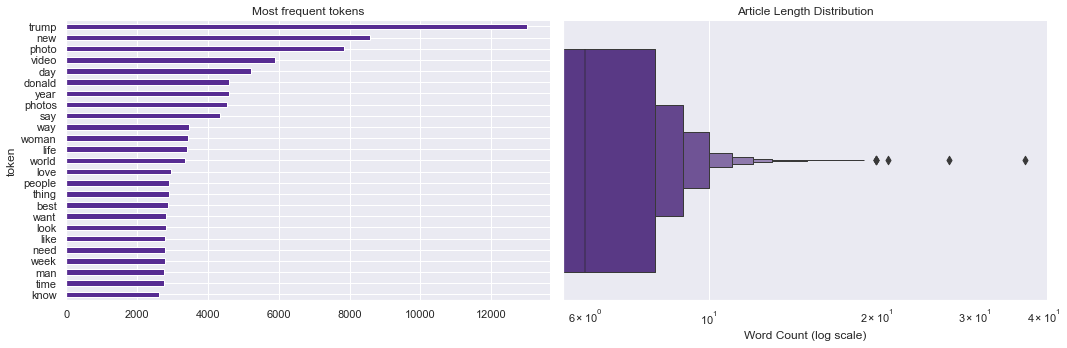

In [99]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)])
 .set_index('token')
 .squeeze()
 .iloc[:25]
 .sort_values()
 .plot
 .barh(ax=axes[0], title='Most frequent tokens'))
sns.boxenplot(x=pd.Series(article_length), ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('Word Count (log scale)')
axes[1].set_title('Article Length Distribution')
sns.despine()
fig.tight_layout()
# fig.savefig(results_path / 'fn_explore', dpi=300);

In [88]:
## load dataset
path = '../../data/News_Category_Dataset_v2.json'
df = load_json_item(path,['headline','category'])

In [89]:
df.head()
df['category'] = df['category'].apply(lambda x: x.lower())

In [90]:
df.head()

,headline,category
0,There Were 2 Mass Shootings In Texas Last Week...,crime
1,Will Smith Joins Diplo And Nicky Jam For The 2...,entertainment
2,Hugh Grant Marries For The First Time At Age 57,entertainment
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,entertainment
4,Julianna Margulies Uses Donald Trump Poop Bags...,entertainment


In [121]:
df = pd.read_csv('../../data/khabar.csv',lineterminator='\n',usecols=['title','cats'])

In [123]:
df['category'] = df['cats'].apply(lambda x: int(eval(x)[0]) if eval(x)!=[] else None)
df = df.dropna()

In [127]:
mapped_category_title = {
    0: "خودرو",
    1: "اخبار سیاسی/اجتماعی",
    2: "اقتصادی",
    3: "سلامت",
    4: "زیبایی و مد",
    5: 'تکنولوژی و دانلود نرم‌افزار',
    6: "گردشگری",
    7: "سرگرمی",
    8: "خانواده و خانه‌داری",
    9: "مسکن",
    10: "مذهبی",
    11: "کتاب و ادبیات",
    12: "موسیقی و کنسرت",
    13: 'سینما، دانلود فیلم و اخبار بازیگران',
    14: "گیم، بازی و ...",
    15: "سایر",
    16: "ورزشی",
    17: 'نوزاد و کودک',
    18: 'سرمایه‌گذاری',
    19: 'همه‌چیز',
    20: 'دانلود بازی، داستان  و ...'
}

In [131]:
df['category'] = df['category'].apply(lambda x: mapped_category_title[x])

In [135]:
import arabic_reshaper
from bidi.algorithm import get_display


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'ﯽﻋﺎﻤﺘﺟﺍ/ﯽﺳﺎﯿﺳ ﺭﺎﺒﺧﺍ'),
  Text(1, 0, 'ﯼﺩﺎﺼﺘﻗﺍ'),
  Text(2, 0, 'ﺭﺍﺰﻓﺍﻡﺮﻧ ﺩﻮﻠﻧﺍﺩ ﻭ ﯼﮊﻮﻟﻮﻨﮑﺗ'),
  Text(3, 0, 'ﯼﺭﺍﺩﻪﻧﺎﺧ ﻭ ﻩﺩﺍﻮﻧﺎﺧ'),
  Text(4, 0, 'ﻭﺭﺩﻮﺧ'),
  Text(5, 0, '... ﻭ  ﻥﺎﺘﺳﺍﺩ ،ﯼﺯﺎﺑ ﺩﻮﻠﻧﺍﺩ'),
  Text(6, 0, 'ﺪﻣ ﻭ ﯽﯾﺎﺒﯾﺯ'),
  Text(7, 0, 'ﯼﺭﺍﺬﮔﻪﯾﺎﻣﺮﺳ'),
  Text(8, 0, 'ﺖﻣﻼﺳ'),
  Text(9, 0, 'ﻥﺍﺮﮕﯾﺯﺎﺑ ﺭﺎﺒﺧﺍ ﻭ ﻢﻠﯿﻓ ﺩﻮﻠﻧﺍﺩ ،ﺎﻤﻨﯿﺳ'),
  Text(10, 0, 'ﯽﺒﻫﺬﻣ'),
  Text(11, 0, 'ﺕﺮﺴﻨﮐ ﻭ ﯽﻘﯿﺳﻮﻣ'),
  Text(12, 0, 'ﮎﺩﻮﮐ ﻭ ﺩﺍﺯﻮﻧ'),
  Text(13, 0, 'ﺰﯿﭼﻪﻤﻫ'),
  Text(14, 0, 'ﯽﺷﺯﺭﻭ'),
  Text(15, 0, 'ﺕﺎﯿﺑﺩﺍ ﻭ ﺏﺎﺘﮐ'),
  Text(16, 0, 'ﯼﺮﮕﺷﺩﺮﮔ')])

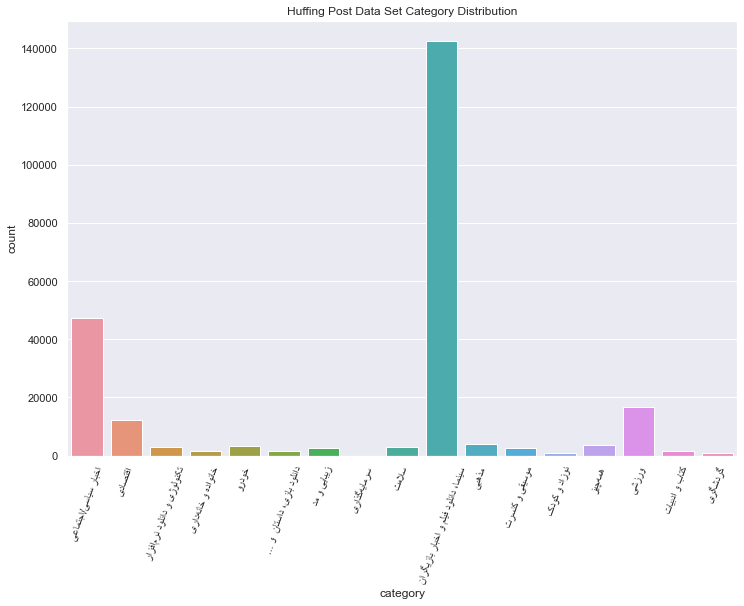

In [136]:
dff= df[['title','category']].groupby('category').count().reset_index()
dff.columns = ['category','count']
dff['category'] = dff['category'].apply(lambda x: get_display(arabic_reshaper.reshape(x)))
plt.title('Huffing Post Data Set Category Distribution')
sns.barplot(x="category", y="count", data=dff)
plt.xticks(rotation=70)